In [1]:
# %pip install tensorflow==2.7 tensorflow-gpu==2.4.1 tensorflow-io matplotlib

In [2]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
# import tensorflow_io as tfio
import librosa as lb
import numpy as np

AUDIO LOADING FUNCTION

In [3]:
def load_wav_16k_mono(filename):
    wave, sr = lb.load(filename, sr = 16000, mono = True)
    return wave

In [4]:
CAPUCHIN_FILE = r'D:\Ganesh\Count Bird Calls\data\Parsed_Capuchinbird_Clips\XC3776-0.wav'
NOT_CAPUCHIN_FILE = r'D:\Ganesh\Count Bird Calls\data\Parsed_Not_Capuchinbird_Clips\afternoon-birds-song-in-forest-0.wav'

In [5]:
wave = load_wav_16k_mono(CAPUCHIN_FILE)
nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
pass

PLOT

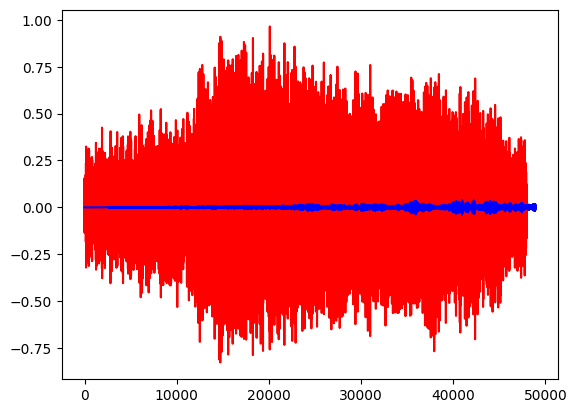

In [6]:
plt.plot(wave, 'red')
plt.plot(nwave, 'blue')
plt.show()

CREATE DATASET

In [7]:
POS = r'D:\Ganesh\Count Bird Calls\data\Parsed_Capuchinbird_Clips'
NEG = r'D:\Ganesh\Count Bird Calls\data\Parsed_Not_Capuchinbird_Clips'
pos = tf.data.Dataset.list_files(POS+'\*.wav')
neg = tf.data.Dataset.list_files(NEG+'\*.wav')
pass

In [8]:
len(list(pos))

217

ADD LABELS AND COMBINE

In [9]:
positives = tf.data.Dataset.zip((pos, tf.data.Dataset.from_tensor_slices(tf.ones(len(list(pos))))))
negatives = tf.data.Dataset.zip((neg, tf.data.Dataset.from_tensor_slices(tf.zeros(len(list(neg))))))
data = positives.concatenate(negatives)

In [10]:
data

<ConcatenateDataset shapes: ((), ()), types: (tf.string, tf.float32)>

CALCULATE AVERAGE LENGTH

In [11]:
lengths = []
for file in os.listdir(r'D:\Ganesh\Count Bird Calls\data\Parsed_Capuchinbird_Clips'):
    tensor_wave = load_wav_16k_mono(os.path.join(r'D:\Ganesh\Count Bird Calls\data\Parsed_Capuchinbird_Clips', file))
    lengths.append(len(tensor_wave))

print(f'Mean = {tf.math.reduce_mean(lengths)}, Min = {tf.math.reduce_min(lengths)}, Max = {tf.math.reduce_max(lengths)}')

Mean = 54156, Min = 32000, Max = 80000


In [12]:
print(f'Mean = {tf.math.reduce_mean(lengths)/16000}, Min = {tf.math.reduce_min(lengths)/16000}, Max = {tf.math.reduce_max(lengths)/16000}')

Mean = 3.38475, Min = 2.0, Max = 5.0


CREATE SPECTROGRAM

In [13]:
def preprocess(file_path, label=None): 
    wav = load_wav_16k_mono(file_path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.image.resize(spectrogram, [350,50])
    return spectrogram, label

VISUALIZE SPECTROGRAM

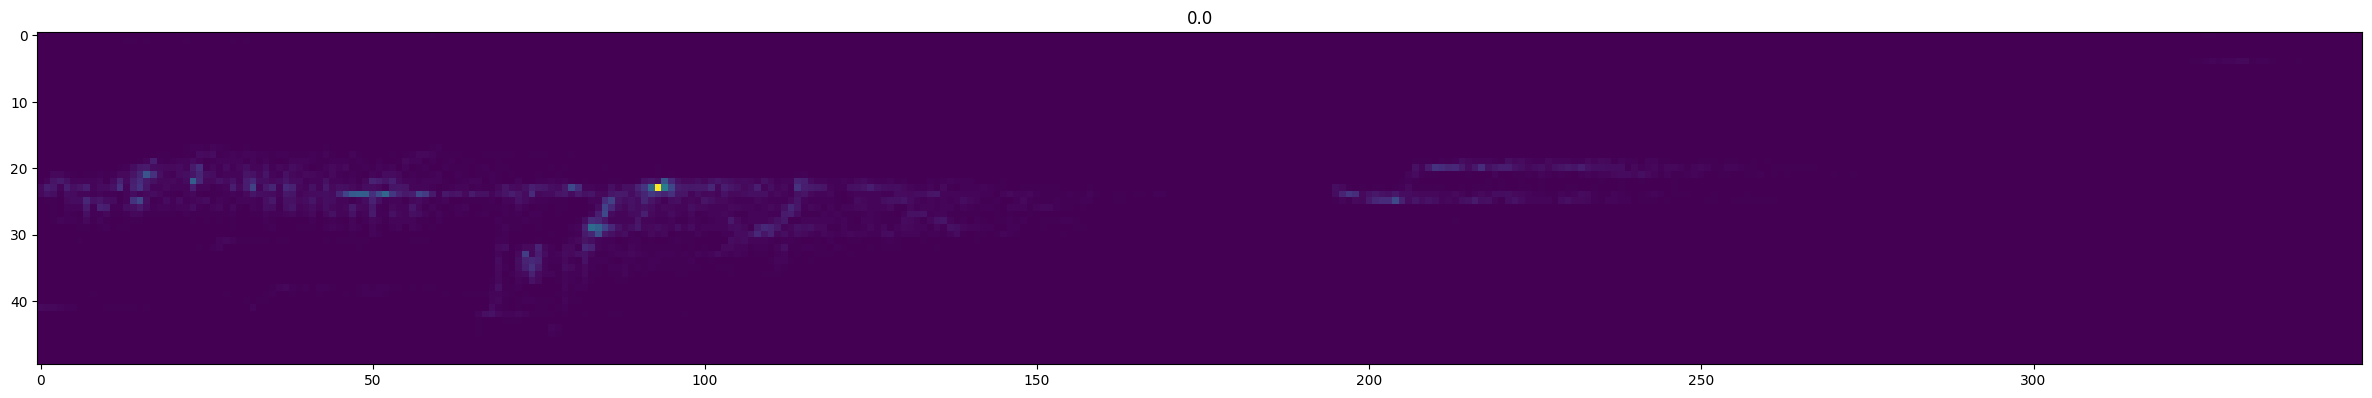

In [15]:
filepath, label = data.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.title(label=label)
plt.show()

TRAINING AND TESTING SPLIT

In [16]:
filenames = [d[0].numpy().decode() for d in list(data)]
labels = [d[1].numpy() for d in list(data)]

In [20]:
filenames[0]

'D:\\Ganesh\\Count Bird Calls\\data\\Parsed_Capuchinbird_Clips\\XC433953-7.wav'

In [17]:
full_data=list(map(preprocess, filenames, labels))

In [18]:
import random
random.shuffle(full_data)

In [19]:
total_data_length = len(full_data)
print(total_data_length)

810


In [20]:
X_full = [d[0] for d in full_data]
Y_full = [d[1] for d in full_data]

In [21]:
X_train = np.array(X_full[:int(total_data_length*0.7)])
Y_train = np.array(Y_full[:int(total_data_length*0.7)])
X_test = np.array(X_full[int(total_data_length*0.7):])
Y_test = np.array(Y_full[int(total_data_length*0.7):])
print(f'{len(X_train)=}, {len(Y_train)=}, {len(X_test)=}, {len(Y_test)=}')

len(X_train)=567, len(Y_train)=567, len(X_test)=243, len(Y_test)=243


BUILD A DEEP LEARNING MODEL

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [23]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(350, 50, 1),))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [24]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 348, 48, 16)       160       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 346, 46, 16)       2320      
_________________________________________________________________
flatten (Flatten)            (None, 254656)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               32596096  
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 32,598,705
Trainable params: 32,598,705
Non-trainable params: 0
_________________________________________________________________


In [25]:
hist = model.fit(x=X_train, y=Y_train, epochs=10, validation_data=(X_test,Y_test))

Epoch 1/10
18/18 [==============================] - 2s 106ms/step - loss: 0.2627 - recall: 0.8503 - precision: 0.8803 - val_loss: 0.0365 - val_recall: 0.9571 - val_precision: 1.0000
Epoch 2/10
18/18 [==============================] - 1s 57ms/step - loss: 0.0279 - recall: 0.9524 - precision: 1.0000 - val_loss: 0.0442 - val_recall: 0.9429 - val_precision: 1.0000
Epoch 3/10
18/18 [==============================] - 1s 57ms/step - loss: 0.0070 - recall: 0.9932 - precision: 1.0000 - val_loss: 0.0124 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 4/10
18/18 [==============================] - 1s 57ms/step - loss: 0.0035 - recall: 0.9932 - precision: 1.0000 - val_loss: 0.0083 - val_recall: 0.9857 - val_precision: 1.0000
Epoch 5/10
18/18 [==============================] - 1s 57ms/step - loss: 8.7283e-04 - recall: 1.0000 - precision: 1.0000 - val_loss: 0.0080 - val_recall: 0.9857 - val_precision: 1.0000
Epoch 6/10
18/18 [==============================] - 1s 57ms/step - loss: 4.8706e-04 - reca

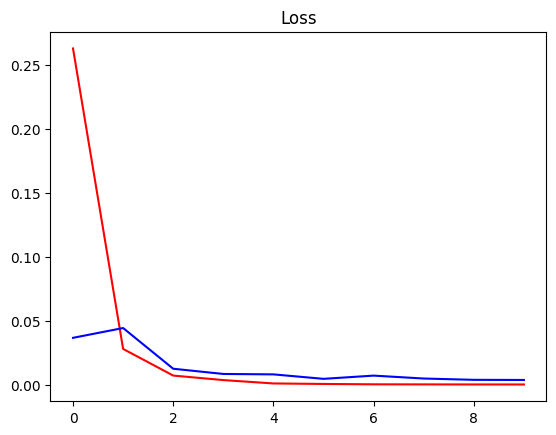

In [26]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r')
plt.plot(hist.history['val_loss'], 'b')
plt.show()

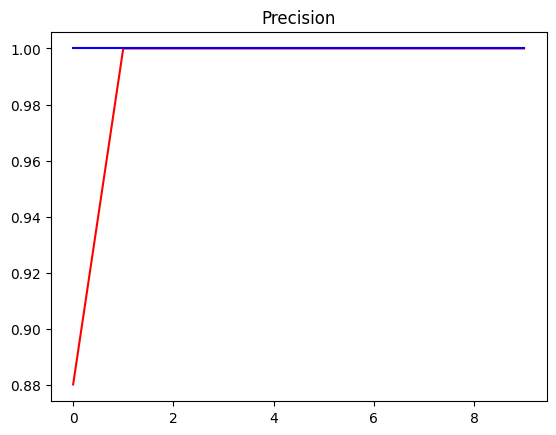

In [27]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r')
plt.plot(hist.history['val_precision'], 'b')
plt.show()

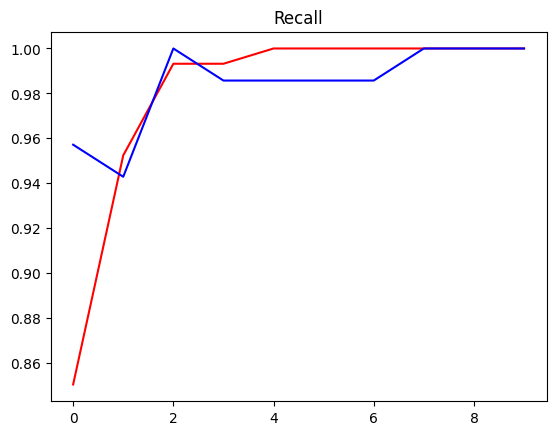

In [28]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r')
plt.plot(hist.history['val_recall'], 'b')
plt.show()

PREDICT ON A SINGLE CLIP

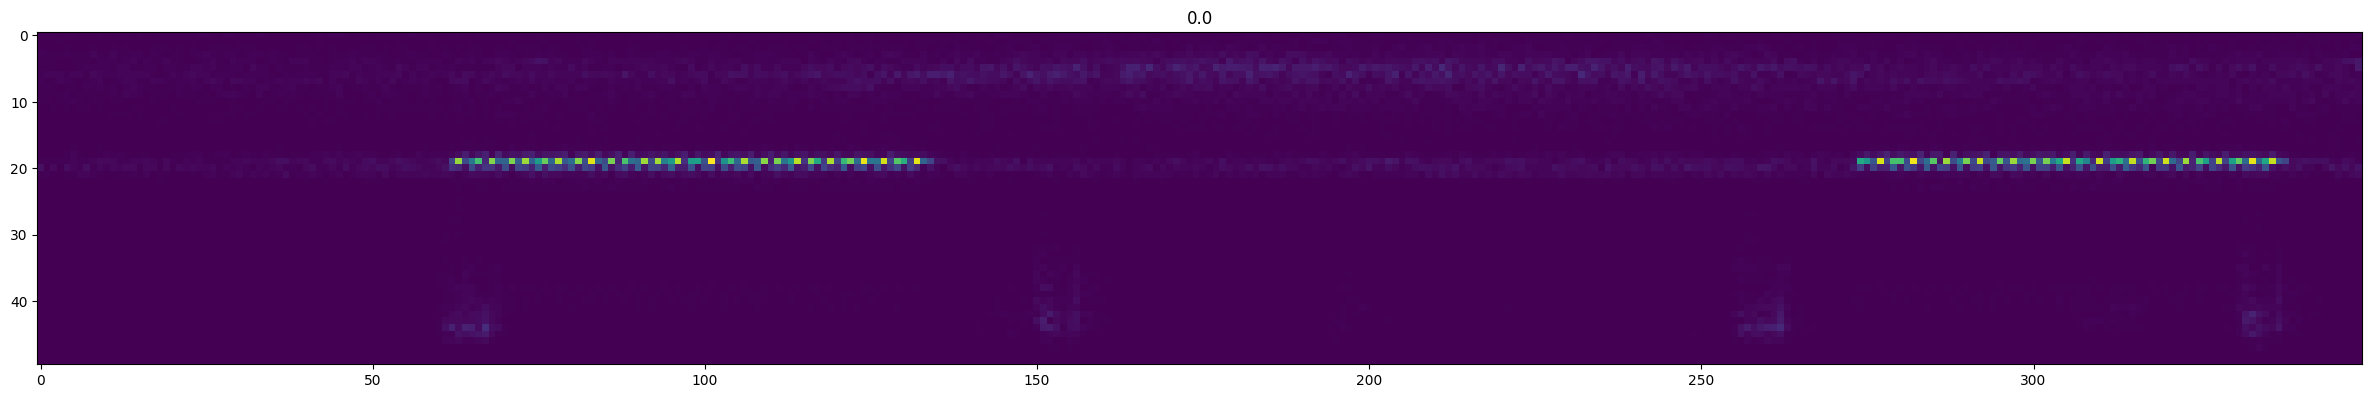

[[0.]]


In [29]:
idx = random.randint(0,len(X_test)-1)
x_sample, y_sample = X_test[idx], Y_test[idx]
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(x_sample)[0])
plt.title(label=y_sample)
plt.show()
y_hat = model.predict(np.array([x_sample]))
print(y_hat)

LOAD FOREST CLIPS

In [30]:
forest_clip = r'D:\Ganesh\Count Bird Calls\data\Forest Recordings\recording_00.mp3'
wave = load_wav_16k_mono(forest_clip)

SPLIT AUDIO CLIP INTO 3 SECOND FRAMES

In [31]:
def split_waveform(waveform, frame_size=3, sample_rate=16000):
    # Calculate the number of samples in each frame
    frame_length = frame_size * sample_rate

    # Split the waveform into frames
    num_frames = len(waveform) // frame_length
    waveform_frames = np.array_split(waveform[:num_frames * frame_length], num_frames)

    return waveform_frames

In [32]:
splits = split_waveform(wave, frame_size=3, sample_rate=16000)
splits

[array([-2.9193885e-07, -1.2563275e-07,  1.1413332e-06, ...,
         1.2617180e-02, -1.5100282e-04,  9.9225286e-03], dtype=float32),
 array([0.03022363, 0.02469743, 0.0007264 , ..., 0.00612366, 0.03106567,
        0.00122339], dtype=float32),
 array([ 0.01897127,  0.01349469,  0.01992792, ..., -0.00460346,
        -0.00562169, -0.00301559], dtype=float32),
 array([-0.00255289, -0.00622254, -0.0077452 , ..., -0.12047838,
        -0.10321438, -0.0571895 ], dtype=float32),
 array([-0.10154323, -0.09172539, -0.02969212, ..., -0.08849435,
        -0.08706158, -0.10729554], dtype=float32),
 array([-0.23311271, -0.30823305, -0.2221023 , ...,  0.00517057,
        -0.00503634, -0.00505841], dtype=float32),
 array([-0.00047694,  0.00134935, -0.00331707, ..., -0.00480431,
        -0.0055003 , -0.006592  ], dtype=float32),
 array([-0.00403008, -0.00377202, -0.00693903, ..., -0.0005664 ,
         0.00478078,  0.00439423], dtype=float32),
 array([0.00048783, 0.00403775, 0.00336707, ..., 0.00249288,

In [33]:
len(splits[0])

48000

GET SPECTROGRAMS FOR ALL SPLIT FRAMES

In [34]:
def wave_to_spectrogram(wav):
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    spectrogram = tf.image.resize(spectrogram, [350,50])
    return spectrogram

In [35]:
def mp3_to_spectrograms(filename):
    wave = load_wav_16k_mono(filename)
    splits = split_waveform(wave, frame_size=3, sample_rate=16000)
    spectrograms = list(map(wave_to_spectrogram, splits))
    return spectrograms

In [36]:
file = r'D:\Ganesh\Count Bird Calls\data\Forest Recordings\recording_00.mp3'
spectrograms = mp3_to_spectrograms(file)
spectrograms

[<tf.Tensor: shape=(350, 50, 1), dtype=float32, numpy=
 array([[[4.99788221e-05],
         [6.14426608e-05],
         [5.71544588e-05],
         ...,
         [6.91022524e-06],
         [8.22829520e-07],
         [1.71800867e-08]],
 
        [[8.47759584e-05],
         [4.78043003e-05],
         [7.40091491e-05],
         ...,
         [8.31539637e-06],
         [4.50257232e-07],
         [5.24717194e-08]],
 
        [[1.57736285e-04],
         [3.07176349e-04],
         [5.28799137e-04],
         ...,
         [1.16875553e-05],
         [9.99475446e-07],
         [1.60827994e-07]],
 
        ...,
 
        [[6.43472731e-01],
         [8.16186816e-02],
         [1.50377959e-01],
         ...,
         [3.33413901e-03],
         [1.79749238e-03],
         [3.51859417e-05]],
 
        [[2.92436391e-01],
         [5.92527129e-02],
         [1.05789222e-01],
         ...,
         [2.91139423e-03],
         [7.98791414e-04],
         [3.90535679e-05]],
 
        [[3.28842700e-01],
        

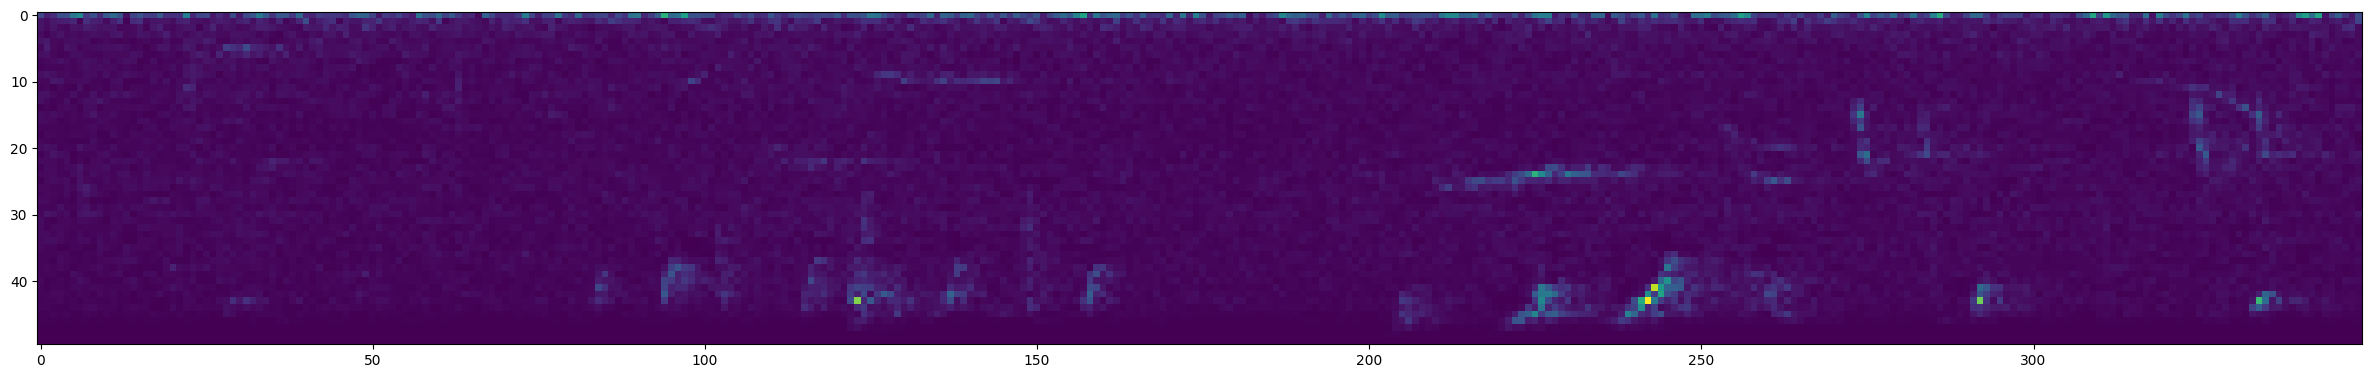

In [45]:
# display random spectrogram
idx = random.randint(0,len(spectrograms)-1)
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrograms[idx])[0])
plt.show()

MAKE PREDICTIONS ON THE SPECTROGRAMS

In [57]:
y_hat = model.predict(np.array(spectrograms))
y_hat = list(map(int,(y_hat>0.5)))
print(y_hat)

[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [53]:
from itertools import groupby

In [54]:
for key,group in groupby(y_hat):
    print(key, group)

0 <itertools._grouper object at 0x000002768DC95DF0>
1 <itertools._grouper object at 0x000002768DC958B0>
0 <itertools._grouper object at 0x000002768DC95DF0>
1 <itertools._grouper object at 0x000002768DC958B0>
0 <itertools._grouper object at 0x000002768DC95DF0>
1 <itertools._grouper object at 0x000002768DC958B0>
0 <itertools._grouper object at 0x000002768DC95DF0>
1 <itertools._grouper object at 0x000002768DC958B0>
0 <itertools._grouper object at 0x000002768DC95DF0>
1 <itertools._grouper object at 0x000002768DC958B0>
0 <itertools._grouper object at 0x000002768DC95DF0>


In [58]:
y_hat = [key for key,group in groupby(y_hat)]
count = sum(y_hat)
print(count)

5


In [59]:
y_hat

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]